# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [11]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value, ±
using Graphs
using JLD2;

In [2]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [3]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 1.0   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

### MPBP

In [4]:
k = 6
svd_trunc = TruncBond(k)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-4

# run MPBP
reset!(bp)
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 8 	 Time: 0:01:42
  Δ:                1.8117205510594558e-5
  SVD Matrix size:  6

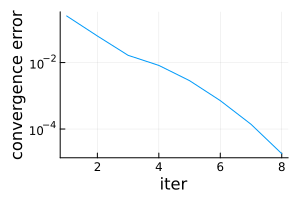

In [5]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [6]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp]
p29_bp = [bb[INFECTED] for bb in b_bp[30]];

### SoftMargin MonteCarlo

In [7]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [12]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
rng = MersenneTwister(1)
nsamples_mc = 2*10^5
sample!(sms, nsamples_mc; rng);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:02:252:08


In [13]:
b_mc = marginals(sms)
p_mc = [[bb[INFECTED]/sum(bb) for bb in b] for b in b_mc];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:22


In [67]:
# estimate probability of epidemic to die out at time `Tdead`
Tdead = T
ids = findall(!all(x[:,Tdead] .== SUSCEPTIBLE) for x in sms.X)
p_dead_epidemic_mc = 1 - sum(sms.w[ids]) / sum(sms.w)
println("Probability of epidemic being wiped out by time $Tdead (MC estimate): ", 
    p_dead_epidemic_mc)

# discard samples where the epidemic was dead by time `Tdead`
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc_trimmed = marginals(sms_new)
p_mc_trimmed = [[bb[INFECTED] for bb in b] for b in b_mc_trimmed];

Probability of epidemic being wiped out by time 50 (MC estimate): 0.014735000000000054


Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:18


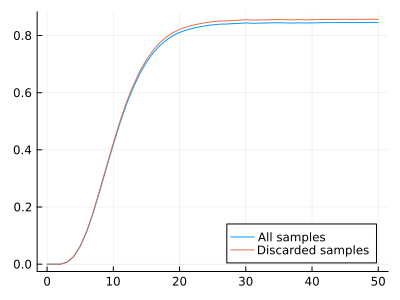

In [17]:
i = 30
plot(0:ΔT:T, value.(p_mc[i]), label="All samples")
plot!(0:ΔT:T, value.(p_mc_trimmed[i]), label="Discarded samples", legend=:bottomright, size=(400,300))

### Discrete DMP

In [18]:
Tdisc = floor(Int, T/ΔT)
ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]
r[1][1] = 1
for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

# dynamic message passing
function dmp_disc!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + 
                (1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i); init=1.0))*(1-r[t-1][i])
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-prod(1-λ*ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=1.0))*(1-ϕ[t-1][id])
        end
    end
    nothing
end
                
dmp_disc!(r, ϕ, Tdisc, bp.g, λ*ΔT, ρ*ΔT)
p_dmp_disc = [[r[t][i] for t in eachindex(r)] for i in 1:N];

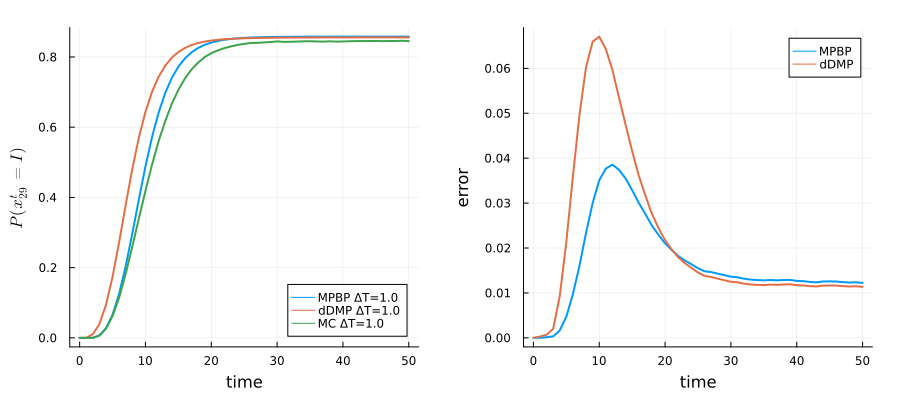

In [69]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="dDMP ΔT=$(ΔT)")
plot!(pl, 0:ΔT:T, value.(p_mc[i]), label="MC ΔT=$(ΔT)")

err_bp = mean(p_bp .- p_mc) .|> value .|> abs
err_dmp_disc = mean(p_dmp_disc .- p_mc) .|> value .|> abs
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="dDMP")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

In [47]:
savefig("discrete_allsamples.pdf")

"/home/crotti/MatrixProductBP/notebooks/discrete_allsamples.pdf"

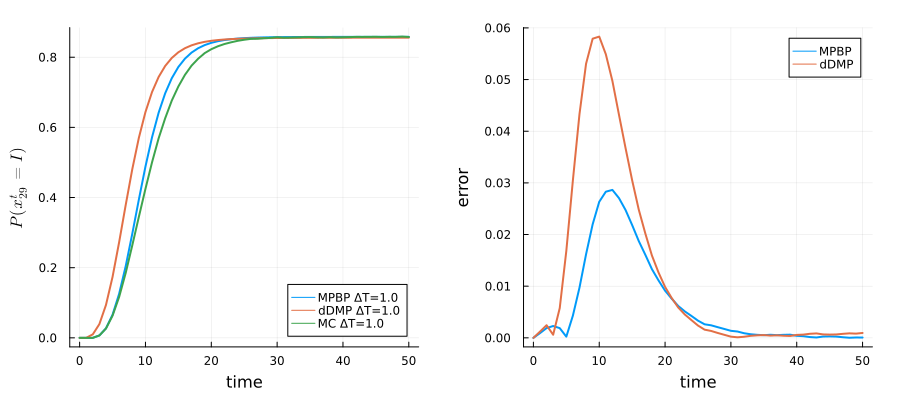

In [70]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:ΔT:T, p_dmp_disc[i], label="dDMP ΔT=$(ΔT)")
plot!(pl, 0:ΔT:T, value.(p_mc_trimmed[i]), label="MC ΔT=$(ΔT)")

err_bp = mean(p_bp .- p_mc_trimmed) .|> value .|> abs
err_dmp_disc = mean(p_dmp_disc .- p_mc_trimmed) .|> value .|> abs
pl_err = plot(xlabel="time", ylabel="error", xticks=0:10:T)
plot!(pl_err, 0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_disc, label="dDMP")

plot(pl, pl_err, size=(900,400), margin=5Plots.mm)

In [66]:
savefig("discrete_discarded.pdf")

"/home/crotti/MatrixProductBP/notebooks/discrete_discarded.pdf"

### Other methods

In [32]:
# cavity master equation
function cme!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])*sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# dynamic message passing
function dmp!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-r[t-1][i])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# individual based mean field
function ibmf!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(r[t-1][src(e)] for e in inedges(g, i); init=0.0)
        end
    end
    nothing
end

ibmf! (generic function with 1 method)

In [37]:
Δt = 1e-4
nT = 50  # number of time steps to be saved
Δtplot = T/nT
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1][1] = 1

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [38]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


In [39]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


In [40]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf[1:Int(Tdisc/nT):end]] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


### Continuous MonteCarlo (Gillespie-like)

In [41]:
# i = 1:N
# p_gill,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
#     discard_dead_epidemics=false);
# p_gill_trimmed,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
#     discard_dead_epidemics=true);

In [42]:
p_gill = [continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
    discard_dead_epidemics=false)[1] for i in 1:N]
p_gill_trimmed = [continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^5, sites=i, Δt=Δtplot,
    discard_dead_epidemics=true)[1] for i in 1:N];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 

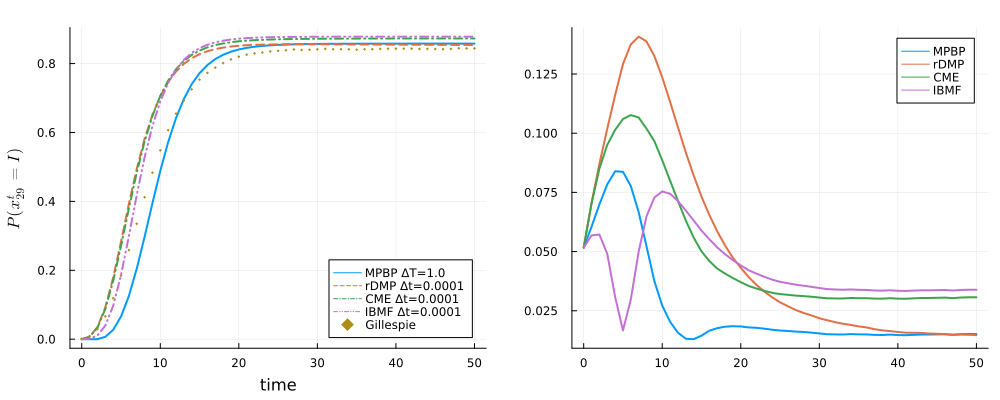

In [58]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

# scatter!(pl, 0:ΔT:T, value.(p_mc[i]), m=:diamond, ms=2, label="MC ΔT=$(ΔT)", msc=:auto)
plot!(pl, 0:Δtplot:T, p_gill[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5, msc=:auto)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp = [mean(abs(p_bp[i][t]-p_gill[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp = [mean(abs(p_dmp[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_cme = [mean(abs(p_cme[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_ibmf = [mean(abs(p_ibmf[i][t]-p_gill[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]

pl_err = plot(0:ΔT:T, err_bp, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp, label="rDMP")
plot!(pl_err, 0:ΔT:T, err_cme, label="CME")
plot!(pl_err, 0:ΔT:T, err_ibmf, label="IBMF")

plot(pl, pl_err)

In [59]:
savefig("continuous_allsamples.pdf")

"/home/crotti/MatrixProductBP/notebooks/continuous_allsamples.pdf"

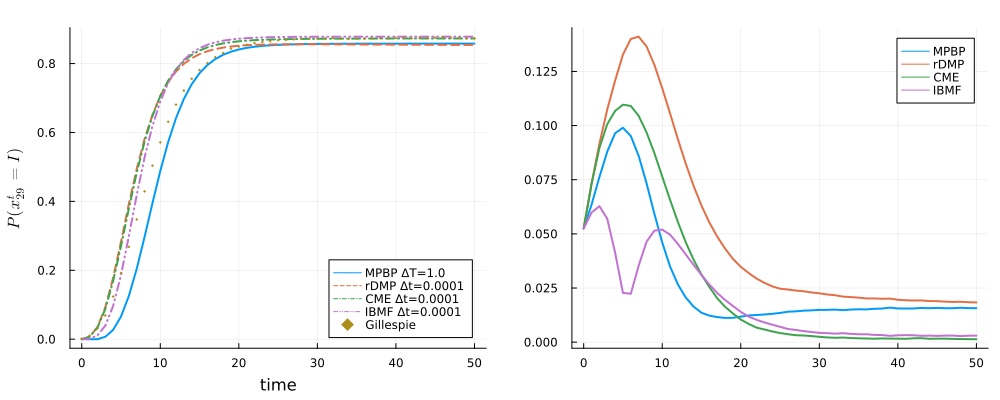

In [60]:
Plots.default(lw=2)
i = 30

pl = plot(xlabel="time", xticks=0:10:T, ylabel=L"P(x_{29}^t=I)", legend=:bottomright)
plot!(pl, 0:ΔT:T, p_bp[i], label="MPBP ΔT=$(ΔT)")
plot!(pl, 0:Δtplot:T, p_dmp[i], ls=:dash, label="rDMP Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_cme[i], ls=:dashdot, label="CME Δt=$(Δt)")
plot!(pl, 0:Δtplot:T, p_ibmf[i], ls=:dashdotdot, label="IBMF Δt=$(Δt)")

# scatter!(pl, 0:ΔT:T, value.(p_mc_trimmed[i]), m=:diamond, ms=2, label="MC ΔT=$(ΔT)", msc=:auto)
plot!(pl, 0:Δtplot:T, p_gill_trimmed[i], label="Gillespie", m=:diamond, st=:scatter, ms=1.5, msc=:auto)
plot!(pl, size=(1000,400), margin=5Plots.mm, legend=:bottomright)

err_bp_trimmed = [mean(abs(p_bp[i][t]-p_gill_trimmed[i][1:floor(Int, ΔT/Δtplot):end][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_dmp_trimmed = [mean(abs(p_dmp[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_cme_trimmed = [mean(abs(p_cme[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]
err_ibmf_trimmed = [mean(abs(p_ibmf[i][t]-p_gill_trimmed[i][t]) for i in 1:N) for t in eachindex(p_bp[1])]

pl_err = plot(0:ΔT:T, err_bp_trimmed, label="MPBP")
plot!(pl_err, 0:ΔT:T, err_dmp_trimmed, label="rDMP")
plot!(pl_err, 0:ΔT:T, err_cme_trimmed, label="CME")
plot!(pl_err, 0:ΔT:T, err_ibmf_trimmed, label="IBMF")

plot(pl, pl_err)

In [61]:
savefig("continuous_discarded.pdf")

"/home/crotti/MatrixProductBP/notebooks/continuous_discarded.pdf"

In [63]:
c_bp = autocovariances(bp);

In [64]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, b_bp, p_bp, p_mc, p_mc_trimmed, Tdead, 
    p_dead_epidemic_mc, p_dmp_disc, p_dmp, p_cme, p_ibmf, p_gill, nT, c_bp, λ, ρ, svd_trunc);